# Non-radial Orbit Correction


In this notebook we will explore the use of an orbit loop up table to correct the implied distance and velocity by relaxing the assumption of radial orbits a bit. We will use the implied distance and radial velocity to search in the precomputed orbits parameter space for the best matching orbit. This orbit will have a velocity vector that will not perfectly align with the galactocentric position vector, meaning that the cross product:

$$ \vec{R} \times \vec{V} = \vec{\Omega} \neq 0 $$

Where $\Omega$ is some non-zero vector that can be computed using the snapshot of the orbit that more closely matches the source. Then:

$$
\bigl(\vec{V}_0 + V_r \,\hat{n} + D \,\vec{\mu}\bigr) \times
\bigl(\vec{R}_0 + D \,\hat{n}\bigr) = \vec{\Omega}.
$$

Taking the dot product with $ \vec{\mu} $ to find the deviation in the velocity, we get:

$$
\vec{\mu} \cdot \Bigl(
\vec{V}_0 \times \vec{R}_0
+ D \, (\vec{V}_0 \times \hat{n})
- V_r \, (\vec{R}_0 \times \hat{n})
+ D \, (\vec{\mu} \times \vec{R}_0)
+ D^2 \, (\vec{\mu} \times \hat{n})
\Bigr)
= \vec{\mu} \cdot \vec{\Omega}.
$$

Which simplifies to:

$$
\vec{\mu} \cdot (\vec{V}_0 \times \vec{R}_0)
+ D \,\vec{\mu} \cdot (\vec{V}_0 \times \hat{n})
- V_r \,\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})
= \vec{\mu} \cdot \vec{\Omega}.
$$

Solving for $ V_r $:

$$
V_r
= \frac{ \vec{\mu} \cdot (\vec{V}_0 \times \vec{R}_0)
+ D\,\vec{\mu} \cdot (\vec{V}_0 \times \hat{n})
- \vec{\mu} \cdot \vec{\Omega}
}{ \vec{\mu} \cdot (\vec{R}_0 \times \hat{n}) }.
$$

Therefore, if we call the purely radial solution $ \tilde{V}_r $, we get:

$$
V_r
= \tilde{V}_r
- \frac{\vec{\mu} \cdot \vec{\Omega}}{\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})}.
$$

Similarly, taking the dot product with $ \hat{n} $ instead of $ \vec{\mu} $ to find the implied distance:

$$
\hat{n} \cdot \Bigl(
\vec{V}_0 \times \vec{R}_0
+ D \, (\vec{V}_0 \times \hat{n})
- V_r \, (\vec{R}_0 \times \hat{n})
+ D \, (\vec{\mu} \times \vec{R}_0)
+ D^2 \, (\vec{\mu} \times \hat{n})
\Bigr)
= \hat{n} \cdot \vec{\Omega}.
$$

Which simplifies to:

$$
(\hat{n} \times \vec{V}_0) \cdot \vec{R}_0
+ D \, \bigl((\hat{n} \times \vec{\mu}) \cdot \vec{R}_0\bigr)
= \hat{n} \cdot \vec{\Omega}.
$$

Solving for $ D $:

$$
D
= \frac{\hat{n} \cdot \vec{\Omega}
+ \hat{n} \cdot (\vec{R}_0 \times \vec{V}_0)}
{ \vec{R}_0 \cdot \bigl(\hat{n} \times \vec{\mu}\bigr)}.
$$

Again, calling the radial solution $ \tilde{D}_I $, we get:

$$
D
= \tilde{D}_I
+ \frac{\hat{n} \cdot \vec{\Omega}}
{ \vec{R}_0 \cdot \bigl(\hat{n} \times \vec{\mu}\bigr)}.
$$

Therefore, the correction to be applied if the trajectory is not strictly radial (given that $ \vec{\Omega} $ is known --- for example, from a lookup table of orbits that reach the current position with a total velocity similar to the source of interest) is as follows. One computes $ \vec{\Omega} $ for the realistic velocity vector, and then applies:

$$
D
= \tilde{D}_I
+ \frac{\hat{n} \cdot \vec{\Omega}}{\vec{R}_0 \cdot (\hat{n} \times \vec{\mu})},
\quad
V_r
= \tilde{V}_r
- \frac{\vec{\mu} \cdot \vec{\Omega}}{\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})}.
$$

Note that if the deviation from a radial orbit is small (1st order perturbation) and given by a small angle $ \delta \alpha $, we will have:

$$
|\vec{\Omega}| = |\vec{R}||\vec{V}|\sin(\delta \alpha) \approx |\vec{R}||\vec{V}| \delta \alpha
$$


# Compute grid of orbits until apocenter

In [1]:
# imports
import agama
import numpy as np
from astropy.coordinates import SkyCoord, Galactocentric
from astropy import units as u
from tqdm import tqdm
import os
import sys
import pandas as pd
from astropy.table import Table
from matplotlib import pyplot as plt

# set current directory to /app/data so we can work with relative paths
os.chdir('/app/data/')

# Add the path to the 'scripts' folder directly
sys.path.append('/app/data/')

from scripts import orbit_integration_agama as oia

#import agama
agama.setUnits(mass=1, length=1, velocity=1)


In [32]:

def compute_orbit_to_first_apocenter( v_ej, theta_rad, phi_rad= 0, r_i= 3, potential_file='Agama/brown2015.pot', n_steps= None, n_steps_f = 1000):
    """
    Compute the orbit trajectory and velocities up to the first apocenter.

    Parameters:
        r_i (float): Initial radius in pc.
        v_ej (float): Ejection velocity in km/s.
        theta_rad (float): Angle from the Z-axis in radians.
        phi_rad (float): Angle from the X-axis to the projection in the galactic plane in radians.
        potential_file (str): Path to the potential file for the integration.
        t_step (float): Integration step in Gyr.

    Returns:
        tuple: Arrays of positions (x, y, z) and velocities (vx, vy, vz) up to the first apocenter.
    """
    # Load the potential
    potential = agama.Potential(file=potential_file)
    
    # Convert spherical to Cartesian coordinates
    x = r_i * np.sin(theta_rad) * np.cos(phi_rad)
    y = r_i * np.sin(theta_rad) * np.sin(phi_rad)
    z = r_i * np.cos(theta_rad)
    vx = v_ej * np.sin(theta_rad) * np.cos(phi_rad)
    vy = v_ej * np.sin(theta_rad) * np.sin(phi_rad)
    vz = v_ej * np.cos(theta_rad)
    
    # Define the initial state
    initial_state = np.array([x, y, z, vx, vy, vz])
    #print(initial_state)
    # check that inital state is an array of Nx6 of float values
    #assert isinstance(initial_state, np.ndarray), 'Initial state must be a numpy array'
    assert initial_state.shape == (6,), 'Initial state must have shape (6,)'
    if initial_state.dtype != np.float64:
        initial_state = initial_state.ravel()
    assert initial_state.dtype == np.float64, 'Initial state must be of type float64'
    
    # Integration settings
    t_max = (300 * u.kpc / (v_ej * u.km / u.s)).to(u.Gyr).value  
    # Max time is defined as the time it takes to
    #  reach the MW virial radius, in practice most objects will not get here but we can guarantee that
    #  all the orbit of interest will exist in this time. 
    
    # Integrate orbit
    # If n_steps is not None, set the trajectory size to n_steps
    if n_steps is not None:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object, trajsize=n_steps)
    # If not, let Agama decide the trajectory size automatically using adaptive step size
    else:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object, trajsize= 0)#, trajsize=int(t_max/t_step))

    # Extract trajectory and velocities
    ts=np.array([t for t in orbit])
    positions = orbit(orbit)[:, :3]
    velocities = orbit(orbit)[:, 3:]

    # Compute radial distances
    radial_distances = np.linalg.norm(positions, axis=1)

    # Find the first apocenter
    for i in range(1, len(radial_distances) - 1):
        if radial_distances[i] > radial_distances[i - 1] and radial_distances[i] > radial_distances[i + 1]:
            apocenter_index = i -1 # The apocenter is the point before the distance starts decreasing, that way the velocity nevere becomes less than zero
            break
    else:
        apocenter_index = len(radial_distances) - 1  # Default to the last point if no apocenter is found



    # Run the orbit again but only up to the first apocenter to get the same number of points for each orbit
    #This works but it might be better to let AGAMA decide on the spacing of the steps in the first orbit and then do it with steps for consistency
    if n_steps is not None:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=np.linspace(0, t_max, n_steps )[apocenter_index], dtype = object, trajsize=n_steps)
    else:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=ts[apocenter_index], dtype = object, trajsize=n_steps_f)
    # Extract trajectory and velocities
    positions = orbit(orbit)[:, :3]
    velocities = orbit(orbit)[:, 3:]

    return positions, velocities, orbit


def doall(nsteps = 1000, N = 10000):
    seed = 3
    rng = np.random.default_rng(seed)
    vej = 10**rng.uniform(2.6, 4, size=N)
    cosa = rng.uniform(0, 1, size=N)
    x, y, z, vx, vy, vz = [], [], [], [], [], []
    orbit_interpolators = [] # this can be used if we want the time steps or other info on the orbit
    for i in tqdm(range(N)):
        pos, vel, orbit = compute_orbit_to_first_apocenter(vej[i], np.arccos(cosa[i]), n_steps_f=nsteps)
        x.append(pos[:,0])
        y.append(pos[:,1])
        z.append(pos[:,2])
        vx.append(vel[:,0])
        vy.append(vel[:,1])
        vz.append(vel[:,2])
        orbit_interpolators.append(orbit)

    return [np.array(_) for _ in [x, y, z, vx, vy, vz, vej, cosa, orbit_interpolators]]


In [33]:
x, y, z, vx, vy, vz, vej, cosa, orbits = doall(nsteps = 1000, N = 10000)

  0%|                                                                                           | 0/10000 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 708.81it/s]


# Check the orbits

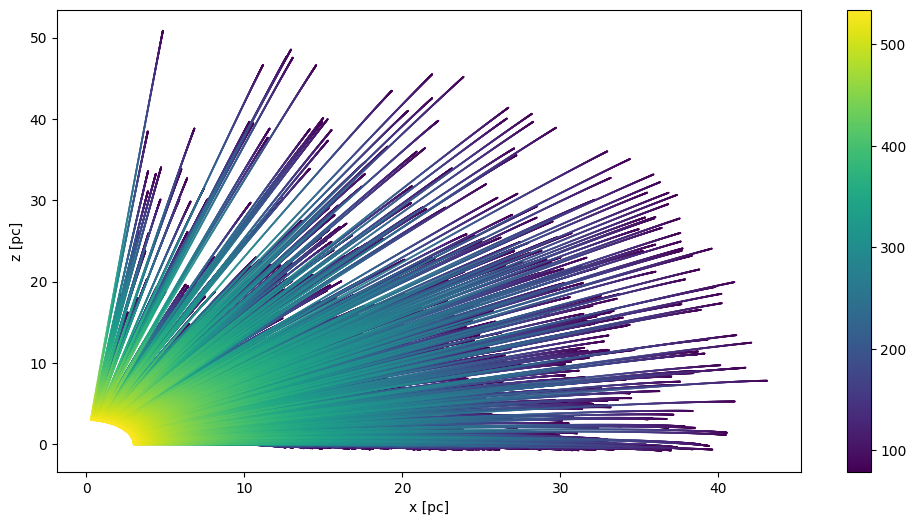

In [40]:
# lets see the first 100 orbits sorted by ejection velocity
mask  = np.argsort(vej)[:1000]

z_slow = z[mask]
x_slow = x[mask]
y_slow = y[mask]
z_slow = z[mask]
vx_slow = vx[mask]
vy_slow = vy[mask]
vz_slow = vz[mask]
vej_slow = vej[mask]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(1000):
    cbar = ax.scatter(x_slow[i], z_slow[i], c = (vx_slow[i]**2 + vz_slow[i]**2)**0.5,s = 0.1)
# add colorbar to see the velocities
plt.colorbar(cbar)
    #ax.scatter(R_slow[i], z_slow[i], c = np.tile(vej_slow[i], len(z_slow[i])), s = 0.1)
#plt.yscale('log')

plt.xlabel('x [pc]')
plt.ylabel('z [pc]')
plt.show()

We see that the orbit works to only get points from ejection until apocenter

# Compute $\Omega$ for each point in each orbit

This is absurdly easy to do since 

In [45]:
# compute Omega for each point in the orbit, in SI units
R_vector = np.array([x.flatten(), y.flatten(), z.flatten()]).T *u.kpc.to(u.meter)
V_vector = np.array([vx.flatten(), vy.flatten(), vz.flatten()]).T *(u.km/u.s).to(u.meter/u.s)
Omega_vector = np.cross(R_vector, V_vector, axis=-1) # This is now Omega(R, z, theta_ej, v_ej)

Omega_amplitude = Omega_vector[:,1] # Omega will always be in the Y direction

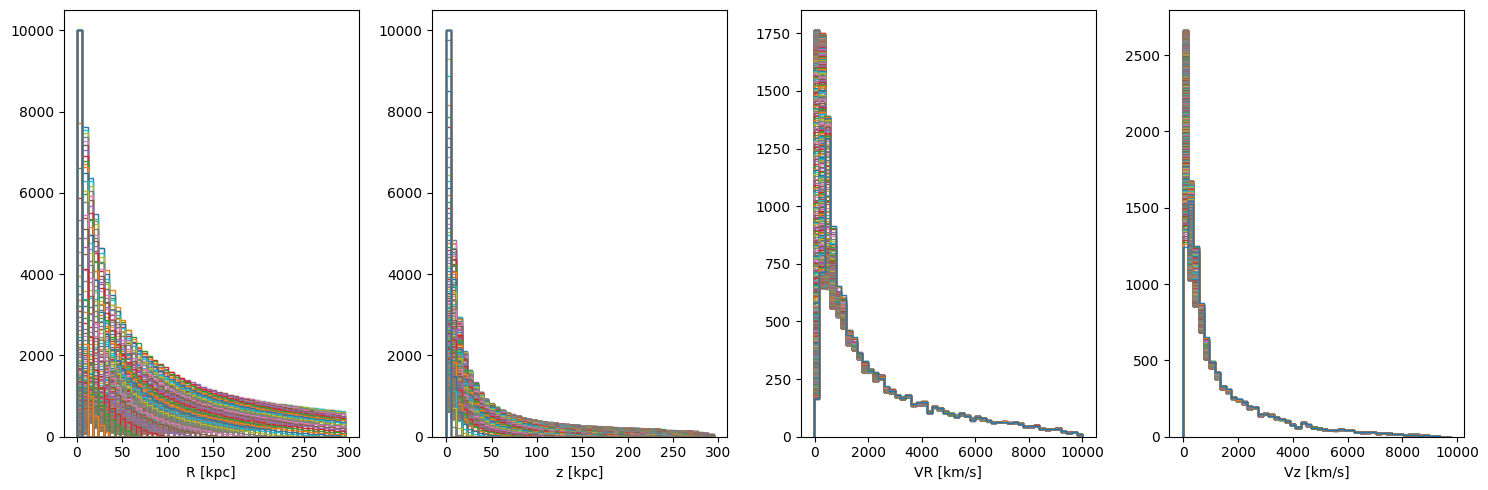

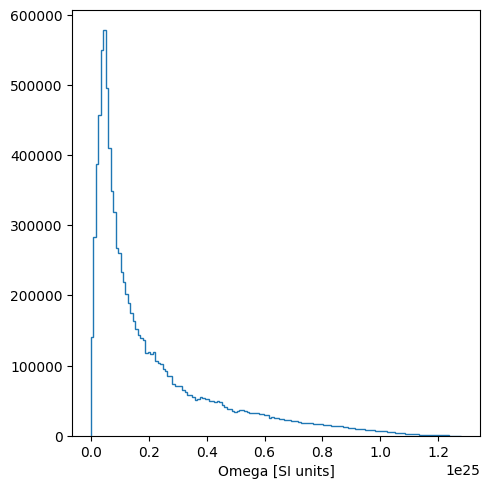

In [81]:
# see the distribution of the parameters
# plot histograms of all the parameters to know the range of interpolation
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].hist(x, bins=50, histtype='step')
ax[0].set_xlabel('R [kpc]')

ax[1].hist(z, bins=50, histtype='step')
ax[1].set_xlabel('z [kpc]')

ax[2].hist(vx, bins=50, histtype='step')
ax[2].set_xlabel('VR [km/s]')

ax[3].hist(vz, bins=50, histtype='step')
ax[3].set_xlabel('Vz [km/s]')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(Omega_amplitude, bins=150, histtype='step')
ax.set_xlabel('Omega [SI units]')
plt.tight_layout()
plt.show()

# Construct interpolator

The goal of this interpolator is given a current positon of a source in cylindrical coordinates and the total velocity, return the corresponding magntiude of $\Omega$. Then the correction term can be calculated.

In [82]:
from logging import warn
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import LinearNDInterpolator

class OrbitInterpolator2D:
    def __init__(self, R, z, Vtot, Omega):
        """
        Initialize the interpolator with precomputed orbit data.

        Parameters:
        - R, z, VR, Vz, t: 2D arrays of shape (n_orbits, n_points_per_orbit).
        """
        # Flatten the data
        self.R = R.flatten()
        self.z = z.flatten()
        # self.V = V.flatten()
        # self.Vz = Vz.flatten()
        self.Vtot =   Vtot.flatten() #np.sqrt(self.VR**2 + self.Vz**2) # I will try to use the total velocity instead of splitting in RZ components

        # Omega should be a flattened array of just the Y component
        self.Omega = Omega 
        #assert np.all(self.Omega >= 0), "All Omega values should be positive!" # seems that Omega can be negative ups


        # Create a KDTree for efficient nearest-neighbor search
        self.tree = cKDTree(np.column_stack((self.R, self.z, self.Vtot)))

        # Create an interpolator for Vz
        self.interpolator = LinearNDInterpolator(
            np.column_stack((self.R, self.z, self.Vtot)),
            self.Omega
        )
    
    def query(self, R, z, Vtot):
        """
        Query the interpolator to find Vz for a given R, z, and total velocity.

        Parameters:
        - R, z, Vtot: Input parameters to match.

        Returns:
        - Interpolated Vz value.
        """
        # Try to interpolate Vz
        Omega_interp = self.interpolator(R, z, Vtot)
        if np.isnan(Omega_interp):  # Fall back to nearest neighbor
                    # Find the nearest neighbor if interpolation fails
            dist, idx = self.tree.query([R, z, Vtot])
            Omega_nearest = self.Omega[idx]
            #warn(f"Interpolation failed at R={R:.2f}, z={z:.2f}, V={Vtot:.2f}! Using nearest neighbor instead.")
            return Omega_nearest
        return Omega_interp


In [96]:

class Omega_interpolator_t:
    def __init__(self, R, z, Vr, Vz, Omega):
        """
        Initialize the interpolator with precomputed orbit data. R referers to cylindrical radius, 
        z to height above the plane, Vtot to the total velocity and Omega is RxV in SI units.

        Here we will test if the interpolator works with the 4D data, and if it can interpolate the Omega values
        since if we try to do it with only R, Z and Vtot it seems to fail or give wrong values.

        Parameters:
        - R, z, VR, Vz, t: 2D arrays of shape (n_orbits, n_points_per_orbit).

        """
        # Flatten the data
        self.R = R.flatten()
        self.z = z.flatten()
        self.Vr = Vr.flatten()
        self.Vz = Vz.flatten()
        #self.Vtot =   Vtot.flatten() #np.sqrt(self.VR**2 + self.Vz**2) # I will try to use the total velocity instead of splitting in RZ components

        # Omega should be a flattened array of just the Y component
        self.Omega = Omega 
        #assert np.all(self.Omega >= 0), "All Omega values should be positive!" # seems that Omega can be negative ups


        # Create a KDTree for efficient nearest-neighbor search
        self.tree = cKDTree(np.column_stack((self.R, self.z, self.Vr, self.Vz)))

        # Create an interpolator for Vz
        self.interpolator = LinearNDInterpolator(
            np.column_stack((self.R, self.z, self.Vr, self.Vz)),
            self.Omega
        )
    
    def query(self, R, z, Vr, Vz):
        """
        Query the interpolator to find Vz for a given R, z, and total velocity.

        Parameters:
        - R, z, Vtot: Input parameters to match.

        Returns:
        - Interpolated Vz value.
        """
        # Try to interpolate Vz
        Omega_interp = self.interpolator(R, z, Vr, Vz)
        if np.isnan(Omega_interp):  # Fall back to nearest neighbor
                    # Find the nearest neighbor if interpolation fails
            dist, idx = self.tree.query([R, z, Vr, Vz])
            Omega_nearest = self.Omega[idx]
            #warn(f"Interpolation failed at R={R:.2f}, z={z:.2f}, V={Vtot:.2f}! Using nearest neighbor instead.")
            return Omega_nearest
        return Omega_interp


In cylindrical coordinates R = x and z = z. There is no component of y in R since we set every orbit to be in the x-z plane. So now we need a function that computes the correction term:


In [97]:
# Create the interpolator for orbital points between 8 and 9 kpc in Galactocentric radius
R_GC = (x**2 + z**2)**0.5
mask = (R_GC > 8) & (R_GC < 9)
R_sub = R_GC[mask]
x_sub = x[mask]
z_sub = z[mask]
vx_sub = vx[mask]
vz_sub = vz[mask]
V_tot = (vx**2 + vz**2)**0.5
V_tot_sub = V_tot[mask]
# Omega is flattened, make it non-flattened for the mask
Omega_non_flat = Omega_amplitude.reshape(x.shape)
Omega_sub = Omega_non_flat[mask]
# Create the interpolator
omega_interpolator = OrbitInterpolator2D(x_sub, z_sub, V_tot_sub, Omega_sub)

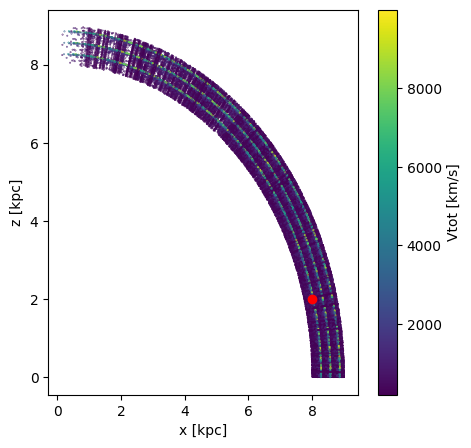

In [91]:
#
test_point = (8, 2, 500)
# plot interpolation range
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cbar = ax.scatter(x_sub, z_sub, c= V_tot_sub, s=0.1)
plt.colorbar(cbar, label='Vtot [km/s]')
ax.scatter(*test_point[:2], c='red', label='Test point')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.show()

In [92]:
print('Interpolation range in x:', x_sub.min(), x_sub.max())
print('Interpolation range in z:', z_sub.min(), z_sub.max())
print('Interpolation range in V:', V_tot_sub.min(), V_tot_sub.max())

Interpolation range in x: 0.15826114046597353 8.999107936061606
Interpolation range in z: 0.0008239689467399839 8.958809008766522
Interpolation range in V: 201.45011986078157 9994.405995976


In [93]:
omega_interpolator.query(*test_point)

array(3.60329474e+24)

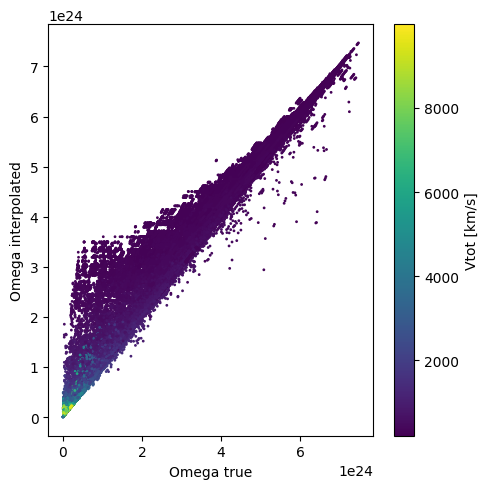

In [94]:
# check the interpolation by querying the interpolator with the same points used to create it
Omega_interp = np.zeros_like(R_sub)
for i in range(len(R_sub)):
    Omega_interp[i] = omega_interpolator.query(x_sub[i], z_sub[i], V_tot_sub[i])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cbar = ax.scatter(Omega_sub, Omega_interp, c = V_tot_sub, s=1)
plt.colorbar(cbar, label='Vtot [km/s]')
ax.set_xlabel('Omega true')
ax.set_ylabel('Omega interpolated')
plt.tight_layout()
plt.show()

With total velocity it seems to overestimate $\Omega$, so lets try with 4 dimensions. Or other parameter combinations


In [98]:
# 4 dimensions
omega_interpolator = Omega_interpolator_t(x_sub, z_sub, vx_sub, vz_sub, Omega_sub)

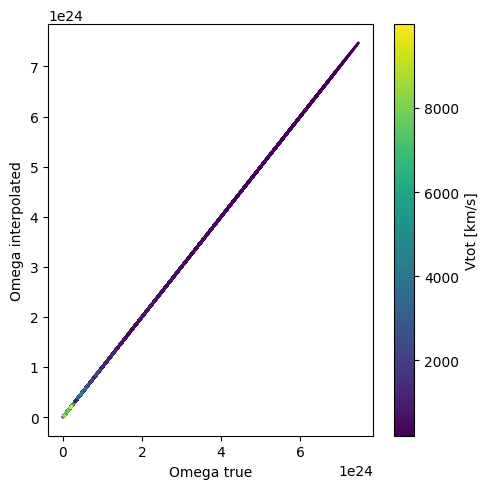

In [99]:
# check the interpolation by querying the interpolator with the same points used to create it
Omega_interp = np.zeros_like(R_sub)
for i in range(len(R_sub)):
    Omega_interp[i] = omega_interpolator.query(x_sub[i], z_sub[i], vx_sub[i], vz_sub[i])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cbar = ax.scatter(Omega_sub, Omega_interp, c = V_tot_sub, s=1)
plt.colorbar(cbar, label='Vtot [km/s]')
ax.set_xlabel('Omega true')
ax.set_ylabel('Omega interpolated')
plt.tight_layout()
plt.show()

The interpolator seems to work just fine. This means I can now create about 297 interpolators in radius bins from 3 kpc to 300 kpc. And save those as pickle files that can then be loaded when querying a specific source. 

In [ ]:
import pickle

# Ensure the folder exists
output_folder = "Data/omega_interpolator_4d"
os.makedirs(output_folder, exist_ok=True)

# Function to create and save interpolators for given radius ranges
for i in range(297):
    r_min = 3 + i  # Starting radius of the range
    r_max = r_min + 1  # Ending radius of the range

    # Create the mask for points within the radius range
    R_GC = (x**2 + z**2)**0.5
    mask = (R_GC > r_min) & (R_GC <= r_max)

    # Subset the data based on the mask
    R_sub = R_GC[mask]
    x_sub = x[mask]
    z_sub = z[mask]
    vx_sub = vx[mask]
    vz_sub = vz[mask]
    V_tot = (vx**2 + vz**2)**0.5
    V_tot_sub = V_tot[mask]
    Omega_non_flat = Omega_amplitude.reshape(x.shape)
    Omega_sub = Omega_non_flat[mask]

    # Create the interpolator
    omega_interpolator = Omega_interpolator_t(x_sub, z_sub, vx_sub, vz_sub, Omega_sub)

    # Save the interpolator to a file
    file_path = os.path.join(output_folder, f"interpolator_{r_min:.0f}-{r_max:.0f}kpc.pkl")
    with open(file_path, "wb") as f:
        pickle.dump(omega_interpolator, f)


In [80]:
min(Omega_amplitude)

np.float64(-274877906944.0)